In [ ]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df=pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
    feature_dup_df=feature_dup_df.reset_index()
    new_feature_name_df=pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
    new_feature_name_df['column_name']=new_feature_name_df[['column_name','dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1]) if x[1]>0 else x[0],axis=1)
    new_feature_name_df=new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df

In [ ]:
import pandas as pd

def get_human_dataset():
    feature_name_df=pd.read_csv('features.txt',sep='\s+',header=None,names=['column_index','column_name'])

    new_feature_name_df=get_new_feature_name_df(feature_name_df)
    feature_name=new_feature_name_df.iloc[:,1].values.tolist()

    X_train=pd.read_csv('X_train.txt',sep='\s+',names=feature_name)
    X_test=pd.read_csv('X_test.txt',sep='\s+',names=feature_name)

    y_train=pd.read_csv('y_train.txt',sep='\s+',header=None,names=['action'])
    y_test=pd.read_csv('y_test.txt',sep='\s+',header=None,names=['action'])

    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=get_human_dataset()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test= get_human_dataset()

start_time= time.time()
gb_clf= GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
gb_pred= gb_clf.predict(X_test)
gb_accuracy= accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:1f} 초".format(time.time()-start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 1315.098573 초


In [ ]:
from sklearn.model_selection import GridSearchCV
params={
    'n_estimators':[100,500],
    'learning_rate':[0.05,0.1]
}
grid_cv= GridSearchCV(gb_clf,param_grid=params,cv=2,verbose=1)
grid_cv.fit(X_train,y_train)
print('최적 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최소 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 500}
최소 예측 정확도:0.9003


In [ ]:
gb_pred=grid_cv.best_estimator_.predict(X_test)
gb_accuracy=accuracy_score(y_test,gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.9396


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
import xgboost

print(xgboost.__version__)

2.1.1


In [25]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset=load_breast_cancer()
X_features=dataset.data
y_label=dataset.target

cancer_df=pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [ ]:
dtrain=xgb.DMatrix(data=X_train,label=y_train)
dtest=xgb.DMatrix(data=X_test,label=y_test)

In [ ]:
params={'max_depth':3,
        'eta':0.1,
        'objective':'binary:logistic',
        'eval_metric':'logloss',
        'early_stoppings':100
    }
num_rounds=400

In [ ]:
wlist=[(dtrain,'train'),(dtest,'eval')]
xgb_model=xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, \
                    early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.58431	eval-logloss:0.56554
[1]	train-logloss:0.51885	eval-logloss:0.50669
[2]	train-logloss:0.46457	eval-logloss:0.45868
[3]	train-logloss:0.41713	eval-logloss:0.41822
[4]	train-logloss:0.37585	eval-logloss:0.38103
[5]	train-logloss:0.34075	eval-logloss:0.35137
[6]	train-logloss:0.31028	eval-logloss:0.32588
[7]	train-logloss:0.28283	eval-logloss:0.30127
[8]	train-logloss:0.25925	eval-logloss:0.28197
[9]	train-logloss:0.23822	eval-logloss:0.26265
[10]	train-logloss:0.21951	eval-logloss:0.24821
[11]	train-logloss:0.20251	eval-logloss:0.23231
[12]	train-logloss:0.18759	eval-logloss:0.22079
[13]	train-logloss:0.17386	eval-logloss:0.20795
[14]	train-logloss:0.16199	eval-logloss:0.19764
[15]	train-logloss:0.15109	eval-logloss:0.18950
[16]	train-logloss:0.14056	eval-logloss:0.18052
[17]	train-logloss:0.13137	eval-logloss:0.17246
[18]	train-logloss:0.12329	eval-logloss:0.16512
[19]	train-logloss:0.11565	eval-logloss:0.15828
[20]	train-logloss:0.10860	eval-logloss:0.15436
[2

In [ ]:
pred_probs=xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

preds=[1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.904 0.004 0.908 0.267 0.992 1.    1.    0.999 0.994 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.metrics import f1_score,confusion_matrix,precision_recall_curve,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [31]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion=confusion_matrix(y_test,pred)
    accuracy=accuracy_score(y_test,pred)
    precision=precision_score(y_test,pred)
    recall=recall_score(y_test,pred)
    f1=f1_score(y_test,pred)

    roc_auc=roc_auc_score(y_test,pred_proba)
    print('오차 행렬')
    print(confusion)

    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [ ]:
get_clf_eval(y_test,preds,pred_probs)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1:0.9744, AUC:0.9951


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

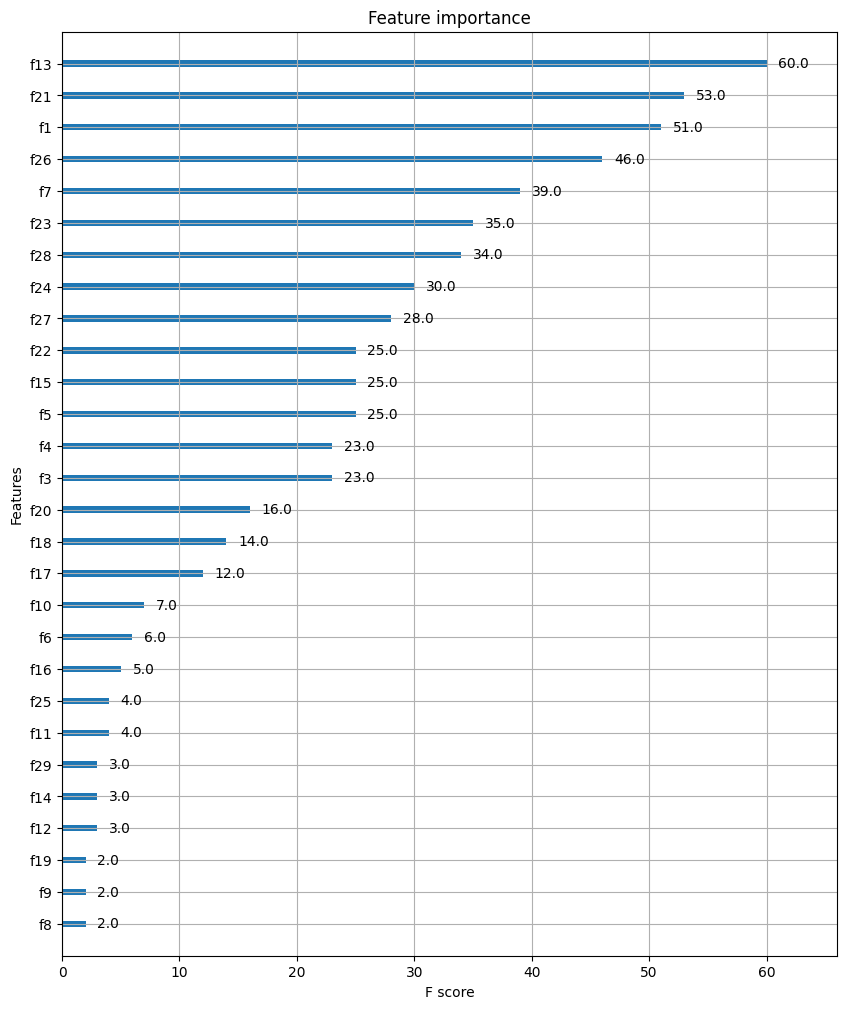

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

In [ ]:
get_clf_eval(y_test,w_preds,w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1:0.9806, AUC:0.9947


In [ ]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals=[(X_test,y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

NameError: name 'ws100_preds' is not defined

In [ ]:
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)

ws10_preds=xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

위의 코드들에 대한 오류를 어떻게 해결해야 할지 모르겠습니다.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

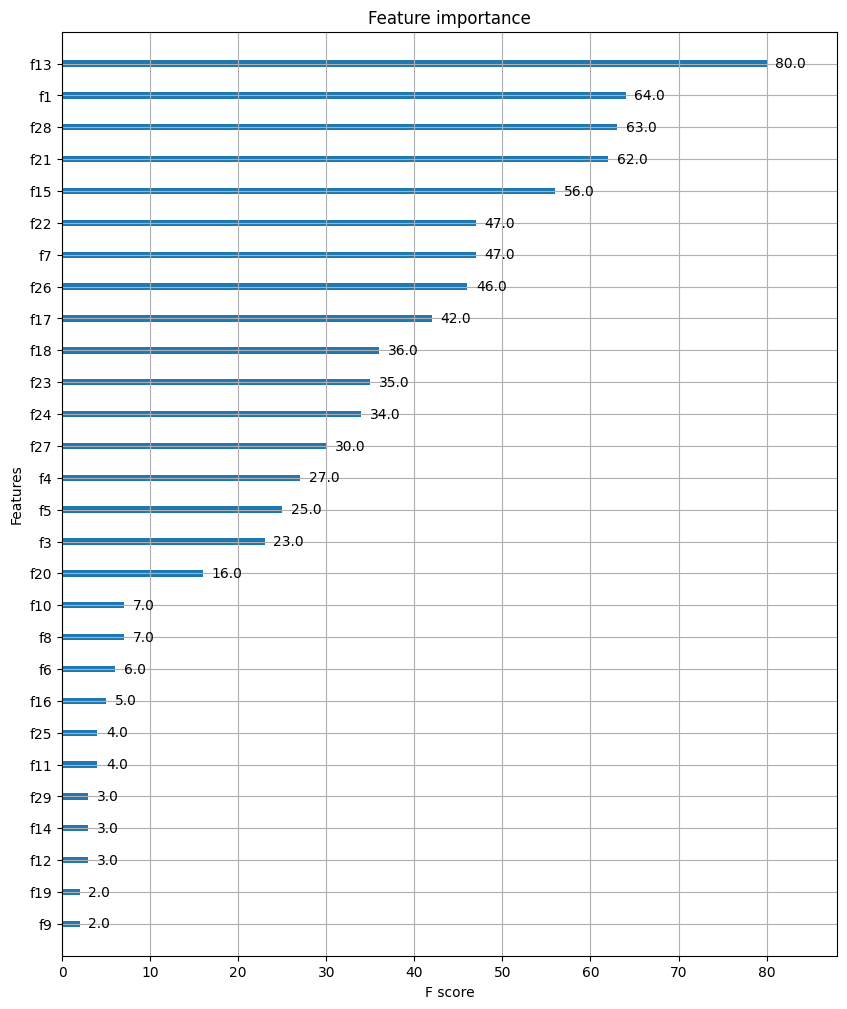

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper, ax=ax)

In [23]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()
ftr=dataset.data
target=dataset.target

X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156)

lgbm_wrapper=LGBMClassifier(n_estimators=400)

evals=[(X_test,y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
preds=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
get_clf_eval(y_test,preds,pred_proba)

NameError: name 'pred_proba' is not defined

NotFittedError: No booster found. Need to call fit beforehand.

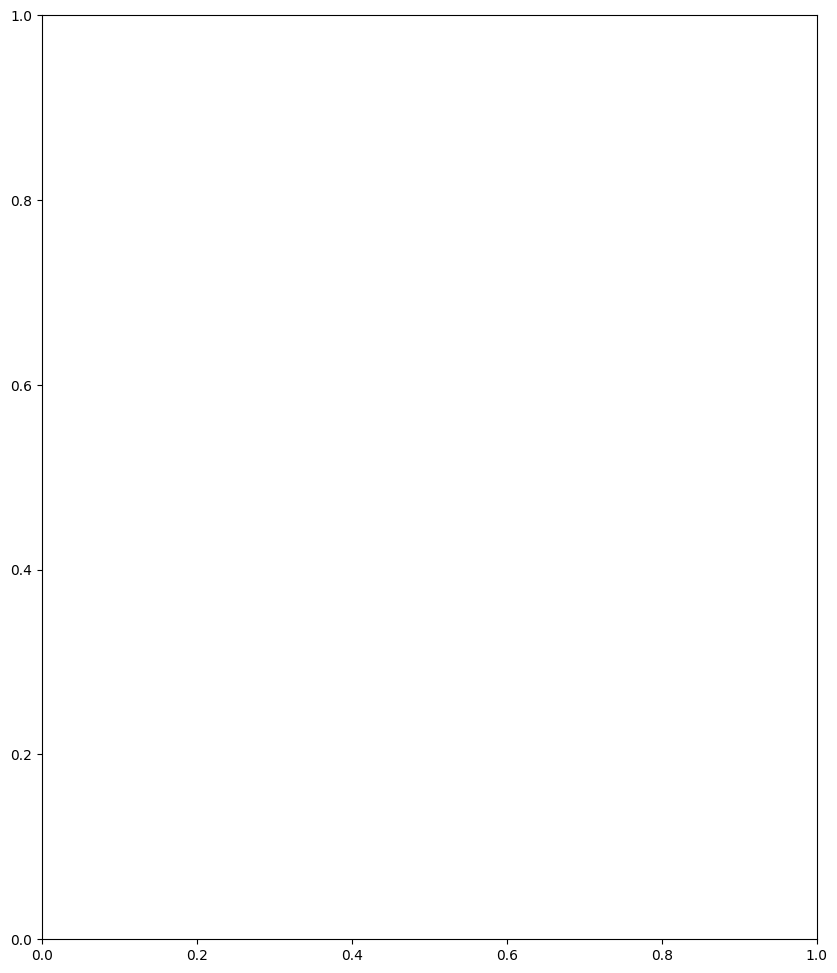

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)

위의 early_stopping_rounds 오류로 인해 뒤의 코드들까지 돌아가지를 않는데, 이를 어떻게 해결해야 할지를 모르겠습니다.

In [4]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()

X_data=cancer_data.data
y_label=cancer_data.target

X_train, X_test, y_train, y_test=train_test_split(X_data,y_label,test_size=0.2,random_state=0)

In [5]:
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100,random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

lr_final=LogisticRegression(C=10)

In [6]:
knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100)

In [7]:
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test,knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test,rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test,ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [8]:
pred=np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)

pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [9]:
lr_final.fit(pred,y_test)
final=lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,final)))

최종 메타 모델의 예측 정확도: 0.9737


In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf=KFold(n_splits=n_folds,shuffle=True,random_state=0)
    train_fold_pred=np.zeros((X_train_n.shape[0],1))
    test_pred=np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__,'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,'시작')
        X_tr=X_train_n[train_index]
        y_tr=y_train_n[train_index]
        X_te=X_train_n[valid_index]

        model.fit(X_tr,y_tr)
        train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)
        test_pred[:,folder_counter]=model.predict(X_test_n)

    test_pred_mean=np.mean(test_pred,axis=1).reshape(-1,1)

    return train_fold_pred, test_pred_mean

In [13]:
knn_train,knn_test=get_stacking_base_datasets(knn_clf,X_train,y_train,X_test,7)
rf_train,rf_test=get_stacking_base_datasets(rf_clf,X_train,y_train,X_test,7)
dt_train,dt_test=get_stacking_base_datasets(dt_clf,X_train,y_train,X_test,7)
ada_train,ada_test=get_stacking_base_datasets(ada_clf,X_train,y_train,X_test,7)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
RandomForestClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
DecisionTreeClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
AdaBoostClassifier model 시작
	 폴드 세트:  0 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  1 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  2 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  3 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  4 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  5 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  6 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [14]:
Stack_final_X_train=np.concatenate((knn_train,rf_train,dt_train,ada_train),axis=1)
Stack_final_X_test=np.concatenate((knn_test,rf_test,dt_test,ada_test),axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape,'원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:',Stack_final_X_train.shape,'스태킹 테스트 피처 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 Shape: (114, 4)


In [ ]:
lr_final.fit(Stack_final_X_train,y_train)
stack_final=lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,stack_final)))

In [15]:
from hyperopt import hp

search_space={'x':hp.quniform('x',-10,10,1), 'y':hp.quniform('y',-15,15,1)}

In [16]:
from hyperopt import STATUS_FAIL

def objective_func(search_space):
    x=search_space['x']
    y=search_space['y']
    retval=x**2-20*y

    return retval

In [17]:
from hyperopt import fmin, tpe, Trials

trial_val=Trials()

best_01=fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5, trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:',best_01)

100%|██████████| 5/5 [00:00<00:00, 157.16trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [18]:
trial_val=Trials()

best_02=fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20, trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:',best_02)

100%|██████████| 20/20 [00:00<00:00, 340.96trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [19]:
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [20]:
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [21]:
import pandas as pd

losses=[loss_dict['loss'] for loss_dict in trial_val.results]

result_df=pd.DataFrame({'x':trial_val.vals['x'], 'y':trial_val.vals['y'], 'losses':losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


In [26]:
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156)

X_tr, X_val, y_tr, y_val=train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [27]:
from hyperopt import hp

xgb_search_space={'max_depth':hp.quniform('max_depth',5,20,1),
                  'min_child_weight':hp.quniform('min_child_weight',1,2,1),
                  'learning_rate':hp.uniform('learning_rate',0.01,0.2),
                  'colsample_bytree':hp.uniform('colsample_bytree',0.5,1)}

In [28]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

def objective_func(search_space):
    xgb_clf=XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                        min_child_weight=int(search_space['min_child_weight']),
                        learning_rate=search_space['learning_rate'],
                        colsample_bytree=search_space['colsample_bytree'],
                        eval_metric='logloss')
    accuracy=cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

    return {'loss':-1*np.mean(accuracy), 'status':STATUS_OK}

In [29]:
from hyperopt import fmin, tpe, Trials

trial_val=Trials()
best=fmin(fn=objective_func,
          space=xgb_search_space,
          algo=tpe.suggest,
          max_evals=50,
          trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:',best)

100%|██████████| 50/50 [00:23<00:00,  2.16trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5026505409854508, 'learning_rate': 0.19828428817109603, 'max_depth': 15.0, 'min_child_weight': 1.0}


In [30]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'],5),round(best['learning_rate'],5),
    int(best['max_depth']),int(best['min_child_weight'])))

colsample_bytree:0.50265, learning_rate:0.19828, max_depth:15, min_child_weight:1


In [32]:
xgb_wrapper=XGBClassifier(n_estimators=400,
                          learning_rate=round(best['learning_rate'],5),
                          max_depth=int(best['max_depth']),
                          min_child_weight=int(best['min_child_weight']),
                          colsample_bytree=round(best['colsample_bytree'],5))

evals=[(X_tr,y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds=xgb_wrapper.predict(X_test)
pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, preds, pred_proba)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

early_stopping_rounds 오류를 어떻게 해결해야 할지 모르겠습니다.